## Mel Spec - DLS on MCV Test
### ResNet50

In [10]:
# !pip install tensorflow pandas keras matplotlib numpy scikit-learn opencv-python

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import cv2
import keras
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import Sequence
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

batch_size = 32
image_shape = (374, 500, 3)
base_dir = "/content/drive/MyDrive/ml-project/dl-sprint/spec/mel-dls-test-clean"

In [13]:
#@title Batch Generator
class DataGenerator(Sequence):

    def __init__(self, X, y, base_dir, batch_size, n_class, shuffle=False):
        self.X = X
        self.y = y
        self.n_class = n_class
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.batch_size = batch_size
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.y))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        assert len(self.X) == len(self.y)
        return int(np.ceil(len(self.y)/self.batch_size))

    def __getitem__(self, index):
        X_batch = self.X[index*self.batch_size : (index+1)*self.batch_size]
        y_batch = self.y[index*self.batch_size : (index+1)*self.batch_size]

        X = self.__data_generation(X_batch)
        y = keras.utils.to_categorical(y_batch, num_classes=self.n_class)
        return X, y

    def __data_generation(self, X_img):
        X = []
        for file in X_img:
            t = cv2.imread(f"{self.base_dir}/{file}", cv2.COLOR_BGR2RGB)
            X.append(t)
        return np.asarray(X)

In [14]:
#@title Model Loading
model = keras.models.load_model("/content/drive/MyDrive/ml-project/mozilla-cv/spec/saved_model/mel_resnet50_mcv_cp_9")

In [15]:
#@title Data Splitting
df = pd.read_csv("/content/drive/MyDrive/ml-project/dl-sprint/spec/mel-dls-test-clean.csv")

print(df.head())

X = df["imgname"]
y_true = df["label"]

print("Total Test Data:", len(df))

                           path gender  label                       imgname
0  common_voice_bn_31710783.mp3   male      1  common_voice_bn_31710783.png
1  common_voice_bn_31710855.mp3   male      1  common_voice_bn_31710855.png
2  common_voice_bn_31591651.mp3   male      1  common_voice_bn_31591651.png
3  common_voice_bn_31591661.mp3   male      1  common_voice_bn_31591661.png
4  common_voice_bn_31593208.mp3   male      1  common_voice_bn_31593208.png
Total Test Data: 876


In [16]:
#@title Data Generation
test_gen  = DataGenerator(X,  y_true,  base_dir=base_dir, n_class=2, batch_size=batch_size)

28/28 [==============================] - 372s 13s/step
              precision    recall  f1-score   support

           0       0.18      0.03      0.04       117
           1       0.87      0.98      0.92       759

    accuracy                           0.85       876
   macro avg       0.52      0.50      0.48       876
weighted avg       0.78      0.85      0.80       876



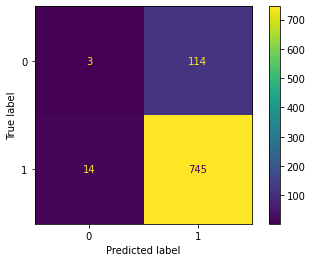

In [17]:
#@title Model Prediction
y_pred = model.predict(test_gen)
y_pred_arg = np.argmax(y_pred, axis=1)

report = classification_report(y_true=y_true, y_pred=y_pred_arg)
print(report)

conf_mat = confusion_matrix(y_true, y_pred_arg)
conf_dis = ConfusionMatrixDisplay(conf_mat)
conf_dis.plot()
plt.show()